In [64]:
# Parameters for CNN
classNames: list = ['お','き','す', 'つ', 'な', 'は', 'ま', 'や', 'れ', 'を'] # duomenų klasės
numClasses: int = len(classNames) # Duomenų klasių skaičius
imageSize: int = 28 # Paveikslėlio dydis
dataSet: int  = 70000 # Duomenų rinkinio dydis
lossFunction = "categorical_crossentropy" # Loss function
modelFileName: str = "model.h5" # Modelio failo pavadinimas

#training data
testSize: float = 0.2 # Testavimo duomenų dydis
batchSize: int = 100 # 
epochs: int = 15 # Epochų skaičius
learningRate: float = 0.01 # Mokymo greitis
momentum: float = 0.9 # 
dropout: float = 0.2 # Išmetimo sluoksnio tikimybė

In [65]:
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib.figure import Figure
from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from keras.callbacks import LearningRateScheduler, TensorBoard
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mnist import MNIST

plt.rcParams['font.family'] = 'Hiragino Maru Gothic Pro'

In [66]:
# # Nuskaitoma informacija is failo
def getData() -> (list, list):
    mndata = MNIST('samples')
    imagesTrain, labelsTrain = mndata.load_training()
    imagesTest, labelsTest = mndata.load_testing()
    return imagesTrain+imagesTest, labelsTrain+labelsTest

# išskaidyti duomenų aibę į mokymo ir testavimo aibes
def splitData(data:list, labels:list, testSize: float) -> (list, list, list, list):
    return train_test_split(data, labels, test_size=testSize, random_state=42)

# Suformuoti masyvus [0,0...1,...0,0], kur vienetas reiškia esamą duomenų klasės reikšmę.
def reshapeLabels(labels: list, numClasses: int) -> list:
    return [ [1 if i == label else 0 for i in range(numClasses)] for label in labels]

# Duomenų aibės elementus padaliname is 255, kad patektų į intevalą [0,1].
def normalizeData(data: list) -> list:
    data = np.array(data)
    return [ i / 255.0 for i in data]

# Duomenų aibę, nuskaitytą iš failo paverčiame į [10000,32,32,3] masyvą, kur 10000 - paveikslėlių kiekis duomenų faile, 32 - paveikslėlio aukštis ir plotis, 3 - RGB spalvu reikšmės.
def reshapeData(data: list, imageSize: int) -> list:
    modifiedData: [[[float]]] = []
    for i in data:
        imageMatrix: [[float]] = []
        for j in range(imageSize):
            combList : [float] = []
            for k in range(imageSize):
                combList.append(i[j*imageSize+k])
            imageMatrix.append(combList)
        modifiedData.append(imageMatrix)
    return modifiedData

# nuskaitomi visi failai, kuriuose yra duomenys, juos performatuojam ir išsaugome į kitus failus.
def prepareData(imageSize: int, numClasses: int) -> (list, list):
    newData: list = []
    newLabels: list = []
    data, labels = getData()
    data = normalizeData(data)
    data = reshapeData(data, imageSize)
    labels = reshapeLabels(labels, numClasses)
    newData.extend(data)
    newLabels.extend(labels)
    newData = np.array(newData)
    newLabels = np.array(newLabels)
    return newData, newLabels

def lenet() -> Sequential: # iki galo issiaiskinti kaip veikia
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=(28,28,1)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(dropout)) # 1
    model.add(Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dropout(dropout)) # 2
    model.add(Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(numClasses, activation = 'softmax', kernel_initializer='he_normal'))
    sgd = optimizers.legacy.SGD(learning_rate=learningRate, momentum=momentum, nesterov=True)
    model.compile(loss=lossFunction, optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

def simple() -> Sequential:
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(28, 28,1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation='softmax', kernel_initializer='he_normal'))
    sgd = optimizers.legacy.SGD(learning_rate=learningRate, momentum=momentum, nesterov=True)
    model.compile(loss=lossFunction, optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model

def scheduler(epoch: int) -> float:
    if epoch < 100:
        return 0.01
    if epoch < 150:
        return 0.005
    return 0.001

# Modelio mokymas naudojantis mokymo ir testavimo duomenimis, bei pateikiant mokymo algorithmą.
def trainModel(trainData: np.array,testData: np.array, trainLabels: np.array, testLabels: np.array, learningModel: callable):
    model: Sequential = learningModel()
    print(model.summary())

    # set callback
    tensorBoard = TensorBoard(log_dir='./lenet', histogram_freq=0)
    change_lr = LearningRateScheduler(scheduler)
    cbks = [change_lr,tensorBoard]

    model.fit(trainData, trainLabels,
                batch_size=batchSize,
                epochs=epochs,
                callbacks=cbks,
                validation_data=(testData, testLabels),
                shuffle=True)

    model.save(modelFileName)

# Esamas duomenų klasės maskes paverčiame į klasės indeksą.
def labelToClass(label: list) -> int:
    for i in range(len(label)):
        if label[i] == 1:
            return i
        
# Turėdami tikimybes klasėms, kurias priskyrė modelis, paverčiame pasiimame klasės indeksą su didžiausią tikimybe.
def probabilityToClass(label:list) -> int:
    return np.argmax(label)

# Palyginame modelio spėjimus su tikromis klasėmis ir paskaičiuojame tikslumą.
def accuracy(predictions: list, labels: list) -> float:
    correct: int = 0
    for i in range(len(predictions)):
        if predictions[i] == labelToClass(labels[i]):
            correct += 1
    return correct / len(predictions)

# Palyginame modelio spėjimus su tikromis klasėmis ir paskaičiuojame vidutinį kvadratinį nuokrypį.
def loss(model: Sequential,data:np.array, labels: np.array) -> float:
    MSE:int = 0
    for i in range(len(data)):
        MSE += np.square(labelToClass(labels[i]) - probabilityToClass(model.predict(data[i])))
    return MSE / len(data)

# Nupiešiame modelio confusion matrix.
def confusionMatrix(model: Sequential, data: np.array, labels: np.array):
    predictions = model.predict(data)
    predictions = [probabilityToClass(i) for i in predictions]
    cm = confusion_matrix([labelToClass(i) for i in labels],predictions)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize = (10,10))
    sns.heatmap(cm, annot=True, xticklabels=classNames, yticklabels = classNames, square=True, cmap='Greens')
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

# Nupiešiame paveikslėlius ir jų spėjimus su tikimybėmis.
def drawImagesAndPredictions(model: Sequential, data: np.array, labels: np.array, rows:int=8, columns: int=8):
    figure: Figure = plt.figure(figsize=(10, 7)) 

    nData: np.array = data[:rows*columns]
    labels: np.array = labels[:rows*columns]

    model = load_model(modelFileName)
    modelPredictions = model.predict(nData)
    modelPredictedClasses = [probabilityToClass(i) for i in modelPredictions]

    for i in range(len(nData)):
        figure.add_subplot(rows, columns, i+1)
        plt.imshow(nData[i],cmap='gray') 
        plt.axis('off')
        title = classNames[modelPredictedClasses[i]] + "\n (" + round(max(modelPredictions[i]),3).__str__() + ")"
        if modelPredictedClasses[i] != labelToClass(labels[i]):
            plt.title(title,color="red")
        else:
            plt.title(title,color="green")
        plt.tight_layout(pad=0.5)

In [67]:
data, labels = prepareData(imageSize, numClasses)

In [68]:
trainData, testData, trainLabels, testLabels = splitData(data, labels, testSize)
trainModel(trainData,testData,trainLabels,testLabels, lenet)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 6)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 6)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 256)              

/Users/pijus/.pyenv/versions/3.11.4/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
model = load_model(modelFileName)

In [70]:
predictionValues = model.predict(testData)
predictionValues = [probabilityToClass(i) for i in predictionValues]
print("accuracy: ", accuracy(predictionValues, testLabels))

438/438 [==============================] - 1s 1ms/step
accuracy:  0.9782857142857143


438/438 [==============================] - 1s 1ms/step


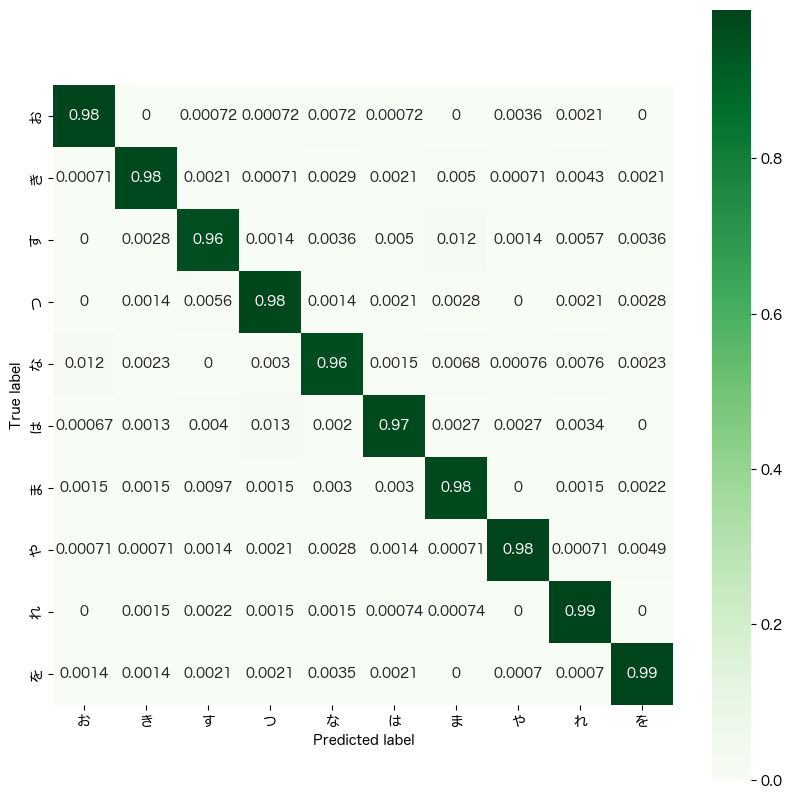

In [71]:
confusionMatrix(model, testData, testLabels)

2/2 [==============================] - 0s 2ms/step


/var/folders/2d/3vb6hz_s28z4y7mpqyhs8nbw0000gq/T/ipykernel_29147/2683519244.py:162: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=0.5)


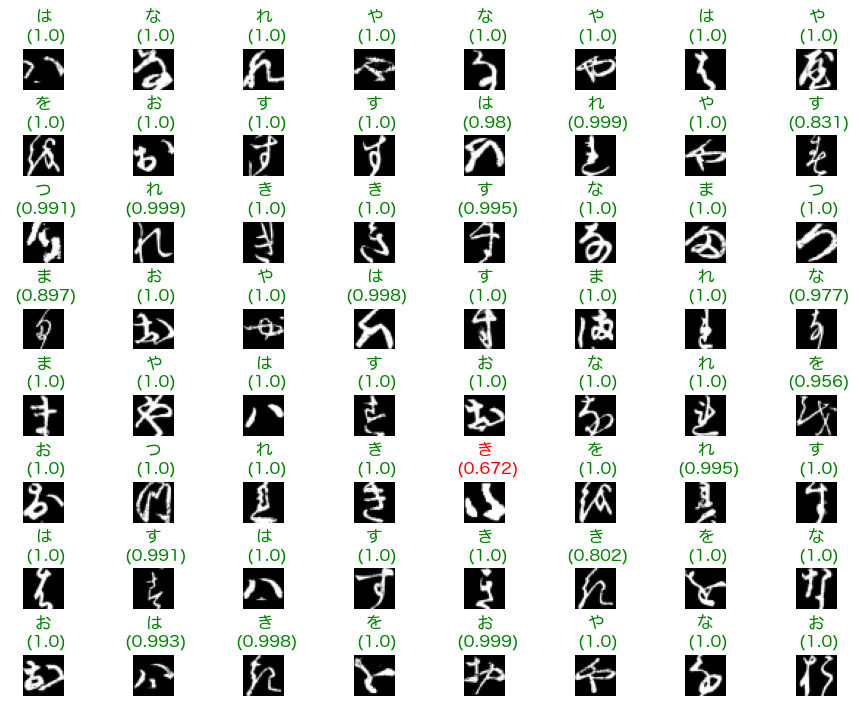

In [72]:
drawImagesAndPredictions(model, testData, testLabels)